# Graph Aware evaluation on Core, CiteSeer and PubMed

## Load font

In [1]:
from pylab import *
from math import sin
rc('text', usetex = False)
la = matplotlib.font_manager.FontManager()
lu = matplotlib.font_manager.FontProperties(family = 'Arial')
print(la.findfont(lu))

/usr/share/fonts/truetype/msttcorefonts/Arial.ttf


## Read and process data

In [2]:
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.utils import add_self_loops

citeseer_dataset = Planetoid(root = "./data", name = "CiteSeer")
cora_dataset = Planetoid(root = "./data", name = "Cora")
pubmed_dataset = Planetoid(root = "./data", name = "PubMed")

def pre_process(dataset):
    dataset.transform = T.NormalizeFeatures()
    return dataset

def add_set(set_name):
    global name_to_sets, name_to_dataset
    name_to_sets[set_name] = dict({})
    
    dataset = name_to_dataset[set_name]
    X =  dataset[0].x 
    y =  dataset[0].y 
    
    test =  dataset[0].test_mask
    train = dataset[0].train_mask 
    val =  dataset[0].val_mask
    
    edge_index = add_self_loops(dataset[0].edge_index)[0]

    name_to_sets[set_name]["X"] = X
    name_to_sets[set_name]["y"] = y
    name_to_sets[set_name]["test"] = test
    name_to_sets[set_name]["train"] = train
    name_to_sets[set_name]["val"] = val
    name_to_sets[set_name]["edge_index"] = edge_index

def create_sets():
    for set_name in name_to_dataset.keys():
        add_set(set_name)


CORA = "Cora"
PUBMED = "PubMed"
CITESEER = "Citeseer"

name_to_dataset = dict({})
name_to_dataset[CORA] = pre_process(cora_dataset)
name_to_dataset[PUBMED] = pre_process(pubmed_dataset)
name_to_dataset[CITESEER] = pre_process(citeseer_dataset)
name_to_sets = dict({})
create_sets()
name_to_sets

{'Cora': {'X': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]),
  'y': tensor([3, 4, 4,  ..., 3, 3, 3]),
  'test': tensor([False, False, False,  ...,  True,  True,  True]),
  'train': tensor([ True,  True,  True,  ..., False, False, False]),
  'val': tensor([False, False, False,  ..., False, False, False]),
  'edge_index': tensor([[   0,    0,    0,  ..., 2705, 2706, 2707],
          [ 633, 1862, 2582,  ..., 2705, 2706, 2707]])},
 'PubMed': {'X': tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0554, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0114, 0.0047,  ..., 0.0000, 0.0000, 0.0000],
          [0.0531, 0.0000, 0.0000,  ..., 0.0000, 0.000

## Hyperparameter search

In [3]:
from sklearn.linear_model import LogisticRegression
from hyperopt import hp
from AutoTune2 import AutoSearch
from sklearn.metrics import accuracy_score
from torch.nn.functional import normalize

lr_choices = {
    'penalty': ["l2"],
    'max_iter': [2**i for i in range(6, 15)],
    
}

space_lr = {
    **{key: hp.choice(key, value) for key, value in lr_choices.items()},
    'tol': hp.loguniform('tol', -11, -3),
    'C': hp.uniform('C', 0.0, 10)
}

def norm_user_function(kwargs):
    return  normalize(kwargs["original_features"] + kwargs["summed_neighbors"], p=2.0, dim = 1)
    
def user_function(kwargs):
    return  kwargs["original_features"] + kwargs["summed_neighbors"]
    

hops = [0,3,8]
clfs = [LogisticRegression]
clfs_space = dict({})
clfs_space["LogisticRegression"] = space_lr
attention_configs = [None,{'inter_layer_normalize': False,
                     'use_pseudo_attention':True,
                     'cosine_eps':.01,
                     'dropout_attn': None}, 
                     {'inter_layer_normalize': True,
                     'use_pseudo_attention':True,
                     'cosine_eps':.01,
                     'dropout_attn': None},
                     {'inter_layer_normalize': True,
                     'use_pseudo_attention':True,
                     'cosine_eps':.001,
                     'dropout_attn': None}]
user_functions = [norm_user_function, user_function]
searcher = AutoSearch(name_to_sets[CORA], max_evals=500, pred_metric = accuracy_score, parallelism=50)
# store = searcher.search(clfs, clfs_space, hops=hops, user_functions= user_functions,
#                         attention_configs = attention_configs)

In [4]:
from sklearn.linear_model import LogisticRegression
from hyperopt import hp
from Auto_Tune_Comb import AutoSearch
from sklearn.metrics import accuracy_score
from torch.nn.functional import normalize
lr_choices = {
    'penalty': ["l2"],
    'max_iter': [2**i for i in range(6, 15)],
    
}

space_lr = {
    **{key: hp.choice(key, value) for key, value in lr_choices.items()},
    'tol': hp.loguniform('tol', -11, -3),
    'C': hp.uniform('C', 0.0, 100)
}

lr_choices_1 = {
    'penalty': ["l2"],
    'max_iter': [2**i for i in range(6, 15)],
    
}

space_lr_1 = {
    **{key: hp.choice(f"{key}_1", value) for key, value in lr_choices_1.items()},
    'tol': hp.loguniform('tol_1', -11, -3),
    'C': hp.uniform('C_1', 0.0, 100)
}

lr_choices_2 = {
    'penalty': ["l2"],
    'max_iter': [2**i for i in range(6, 15)],
    
}

space_lr_2 = {
    **{key: hp.choice(f"{key}_2", value) for key, value in lr_choices_2.items()},
    'tol': hp.loguniform('tol_2', -11, -3),
    'C': hp.uniform('C_2', 0.0, 100)
}

def norm_user_function(kwargs):
    return  normalize(kwargs["original_features"] + kwargs["summed_neighbors"], p=2.0, dim = 1)
    
def user_function(kwargs):
    return  kwargs["original_features"] + kwargs["summed_neighbors"]
    

hops_list = [[0,3, 8]]
clfs = [LogisticRegression]
clfs_space = dict({})
clfs_space["LogisticRegression"] = [space_lr, space_lr_1,space_lr_2]
attention_configs = [{'inter_layer_normalize': True,
                     'use_pseudo_attention':True,
                     'cosine_eps':.01,
                     'dropout_attn': None}]
user_functions = [user_function]
searcher = AutoSearch(name_to_sets[PUBMED], max_evals=300, pred_metric = accuracy_score, parallelism=50)
# store_cora = searcher.search(clfs, clfs_space, hops_list=hops_list, user_functions= user_functions,
#                         attention_configs = attention_configs)

In [5]:
from sklearn.linear_model import LogisticRegression
from hyperopt import hp
from Auto_Tune_Comb import AutoSearch
from sklearn.metrics import accuracy_score
from torch.nn.functional import normalize

lr_choices = {
    'penalty': ["l2"],
    'max_iter': [2**i for i in range(6, 15)],
    
}

space_lr = {
    **{key: hp.choice(key, value) for key, value in lr_choices.items()},
    'tol': hp.loguniform('tol', -11, -3),
    'C': hp.uniform('C', 0.0, 10)
}

def norm_user_function(kwargs):
    return  normalize(kwargs["original_features"] + kwargs["summed_neighbors"], p=2.0, dim = 1)
    
def user_function(kwargs):
    return  kwargs["original_features"] + kwargs["summed_neighbors"]
    

hops_list = [[0,3,6]]
clfs = [LogisticRegression]
clfs_space = dict({})
clfs_space["LogisticRegression"] = space_lr
attention_configs = [{'inter_layer_normalize': False,
                     'use_pseudo_attention':True,
                     'cosine_eps':.01,
                     'dropout_attn': None}, 
                     {'inter_layer_normalize': True,
                     'use_pseudo_attention':True,
                     'cosine_eps':.01,
                     'dropout_attn': None}]
user_functions = [user_function]
searcher = AutoSearch(name_to_sets[CITESEER], max_evals=100, pred_metric = accuracy_score, parallelism=50)
# store = searcher.search(clfs, clfs_space, hops_list=hops_list, user_functions= user_functions,
#                         attention_configs = attention_configs)

## Generic fit function for GraphAware training

## Dictionary for storing trained models

In [6]:
name_to_model = dict({})

In [7]:
from EnsembleFramework import Framework
import time

def fit_dataset(set_name,user_functions=[], hops_list= [3], clfs = [], attention_configs= []):
    dataset = name_to_sets[set_name]
    y = dataset["y"]
    
    start = time.time()
    framework = Framework(user_functions, 
                     hops_list=hops_list, ## to obtain best for local neighborhood
                     clfs=clfs,
                     gpu_idx=0,
                     handle_nan=0.0,
                    attention_configs=attention_configs)
    vals = framework.get_features(dataset["X"], dataset["edge_index"], dataset["val"])
    vals = [val.cpu() for val in vals]
    kwargs_list=[{"eval_set":[(vals[i], y[dataset["val"]])], "early_stopping_rounds":5} if clf.__class__.__name__ == 'XGBClassifier' else {} for i, clf in enumerate(clfs)]
    framework.fit(dataset["X"], dataset["edge_index"], y, dataset["train"], kwargs_list)
    end = time.time()-start
    name_to_model[set_name] = framework
    return framework, end

## Generic predict function for GraphAware evaluation

In [8]:
from sklearn.metrics import accuracy_score

def predict_dataset(set_name,framework):
    dataset = name_to_sets[set_name]
    
    y = dataset["y"]
    framework = name_to_model[set_name]
    pred = framework.predict(dataset["X"], dataset["edge_index"], dataset["test"]) 
    pred_val = framework.predict(dataset["X"], dataset["edge_index"], dataset["val"]) 
    y_test = y[dataset["test"]]
    y_val = y[dataset["val"]]
    return {
        "test_acc": accuracy_score(y_test, pred),
        "val_acc": accuracy_score(y_val, pred_val)
    }

## Citeseer Evaluation

### CiteSeer Hyperparameters

In [9]:
from sklearn.linear_model import LogisticRegression
from AutoTune2 import upd_user_function, norm_user_function, user_function
citeseer_store = {'LogisticRegression': {0: {'train_acc': 1.0,
   'val_acc': 0.594,
   'test_acc': 0.615,
   'model': LogisticRegression(C=3.9057765563512103,
                      max_iter=512, tol=0.00037394547447174774),
   'user_function': user_function,
   'attention_config': {'inter_layer_normalize': True,
    'use_pseudo_attention': True,
    'cosine_eps': 0.01,
    'dropout_attn': None}},
  3: {'train_acc': 0.95,
   'val_acc': 0.716,
   'test_acc': 0.721,
   'model': LogisticRegression(C=3.161729301367482, 
                      max_iter=128, tol=0.0022154364103027916),
   'user_function': user_function,
   'attention_config': {'inter_layer_normalize': False,
    'use_pseudo_attention': True,
    'cosine_eps': 0.01,
    'dropout_attn': None}},
  8: {'train_acc': 0.9583333333333334,
   'val_acc': 0.738,
   'test_acc': 0.721,
   'model': LogisticRegression(C=4.484384767955908,
                      max_iter=16384, tol=0.000418404361811845),
   'user_function': user_function,
   'attention_config': {'inter_layer_normalize': False,
    'use_pseudo_attention': True,
    'cosine_eps': 0.01,
    'dropout_attn': None}}}}

### GraphAware on CiteSeer 

In [10]:
store = citeseer_store
user_functions = [store["LogisticRegression"][0]["user_function"], store["LogisticRegression"][3]["user_function"], store["LogisticRegression"][8]["user_function"]]
clfs = [store["LogisticRegression"][0]["model"], store["LogisticRegression"][3]["model"], store["LogisticRegression"][8]["model"]]
attention_configs = [store["LogisticRegression"][0]["attention_config"], store["LogisticRegression"][3]["attention_config"], store["LogisticRegression"][8]["attention_config"]]
times = []
accs = []
for i in range(1):
    framework, end_time = fit_dataset(CITESEER,user_functions=user_functions, hops_list= [0,3,8], clfs = clfs, attention_configs= attention_configs)
    acc_dict = predict_dataset(CITESEER, framework)
    times.append(end_time)
    accs.append(acc_dict["test_acc"])

/home/dwalke/git/graph_aware_ml/EnsembleFramework.py:160: UserWarning: The reduce argument of torch.scatter with Tensor src is deprecated and will be removed in a future PyTorch release. Use torch.scatter_reduce instead for more reduction options. (Triggered internally at ../aten/src/ATen/native/TensorAdvancedIndexing.cpp:230.)
  summed_exp_score = torch.zeros_like(exp_score).scatter(0, target,exp_score, reduce="add")


In [11]:
import numpy as np
print(f"Accuracy of CiteSeer {np.array(accs).mean()} +- {np.array(accs).std()}; Required training time: {np.array(times).mean()}")

Accuracy of CiteSeer 0.72 +- 0.0; Required training time: 2.402418851852417


## PubMed Evaluation

### PubMed Hyperparameters

In [12]:
from AutoTune2 import upd_user_function, norm_user_function
from sklearn.linear_model import LogisticRegression
pubmed_store = {'LogisticRegression': {0: {'train_acc': 0.9833333333333333,
   'val_acc': 0.742,
   'test_acc': 0.737,
   'model': LogisticRegression(C=19.012946053218332, max_iter=4096,
                      tol=0.011693958862167635),
   'user_function': upd_user_function,
   'attention_config': {'inter_layer_normalize': True,
    'use_pseudo_attention': True,
    'cosine_eps': 0.001,
    'dropout_attn': None}},
  3: {'train_acc': 0.9833333333333333,
   'val_acc': 0.812,
   'test_acc': 0.802,
   'model': LogisticRegression(C=2.3417904147486635, max_iter=4096,
                      tol=1.877242326314165e-05),
   'user_function': norm_user_function,
   'attention_config': {'inter_layer_normalize': False,
    'use_pseudo_attention': True,
    'cosine_eps': 0.01,
    'dropout_attn': None}},
  8: {'train_acc': 0.9666666666666667,
   'val_acc': 0.826,
   'test_acc': 0.793,
   'model': LogisticRegression(C=8.816857543671555, max_iter=256, tol=0.0003864950814262107),
   'user_function': norm_user_function,
   'attention_config': None}}}

### GraphAware on PubMed

In [13]:
from tqdm.notebook import tqdm
store = pubmed_store
user_functions = [store["LogisticRegression"][0]["user_function"], store["LogisticRegression"][3]["user_function"], store["LogisticRegression"][8]["user_function"]]
clfs = [store["LogisticRegression"][0]["model"], store["LogisticRegression"][3]["model"], store["LogisticRegression"][8]["model"]]
attention_configs = [store["LogisticRegression"][0]["attention_config"], store["LogisticRegression"][3]["attention_config"], store["LogisticRegression"][8]["attention_config"]]
times = []
accs = []
for i in tqdm(range(1)):
    framework, end_time = fit_dataset(PUBMED,user_functions=user_functions, hops_list= [0,3,8], clfs = clfs, attention_configs= attention_configs)
    acc_dict = predict_dataset(PUBMED, framework)
    times.append(end_time)
    accs.append(acc_dict["test_acc"])


  0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
import numpy as np
print(f"Accuracy of PuBMed {np.array(accs).mean()} +- {np.array(accs).std()}; Required training time: {np.array(times).mean()}")

Accuracy of PuBMed 0.802 +- 0.0; Required training time: 1.5455207824707031


## Cora Evaluation

### Cora Hyperparameters

In [15]:
from sklearn.linear_model import LogisticRegression
from AutoTune2 import user_function, norm_user_function
cora_store = {'LogisticRegression': {0: {'train_acc': 0.9928571428571429,
   'val_acc': 0.586,
   'test_acc': 0.598,
   'model': LogisticRegression(C=9.89464848441749, l1_ratio=0.1083794378326286,
                      max_iter=8192, tol=3.9088643651368724e-05),
   'user_function': user_function,
   'attention_config': {'inter_layer_normalize': True,
    'use_pseudo_attention': True,
    'cosine_eps': 0.001,
    'dropout_attn': None}},
  3: {'train_acc': 0.9928571428571429,
   'val_acc': 0.808,
   'test_acc': 0.82,
   'model': LogisticRegression(C=4.9289832447362025, l1_ratio=0.1761472021705791,
                      max_iter=8192, tol=0.017104071425396022),
   'user_function': norm_user_function,
   'attention_config': None},
  8: {'train_acc': 0.9928571428571429,
   'val_acc': 0.808,
   'test_acc': 0.817,
   'model': LogisticRegression(C=3.726771337407598, l1_ratio=0.032154684509317244,
                      max_iter=128, tol=7.557643967339885e-05),
   'user_function': norm_user_function,
   'attention_config': {'inter_layer_normalize': True,
    'use_pseudo_attention': True,
    'cosine_eps': 0.001,
    'dropout_attn': None}}}}

### GraphAware on Cora

In [16]:
import time
store = cora_store
user_functions = [store["LogisticRegression"][0]["user_function"], store["LogisticRegression"][3]["user_function"], store["LogisticRegression"][8]["user_function"]]
clfs = [store["LogisticRegression"][0]["model"], store["LogisticRegression"][3]["model"], store["LogisticRegression"][8]["model"]]
attention_configs = [store["LogisticRegression"][0]["attention_config"], store["LogisticRegression"][3]["attention_config"], store["LogisticRegression"][8]["attention_config"]]

times = []
accs = []
for i in range(1):
    framework, end_time = fit_dataset(CORA,user_functions=user_functions, hops_list= [0,3,8], clfs = clfs, attention_configs= attention_configs)
    acc_dict = predict_dataset(CORA, framework)
    print(acc_dict)
    times.append(end_time)
    accs.append(acc_dict["test_acc"])

/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


{'test_acc': 0.831, 'val_acc': 0.818}


In [17]:
import numpy as np
print(f"Accuracy of Cora {np.array(accs).mean()} +- {np.array(accs).std()}; Required training time: {np.array(times).mean()}")

Accuracy of Cora 0.831 +- 0.0; Required training time: 0.9124510288238525


## Feature importance for CORA

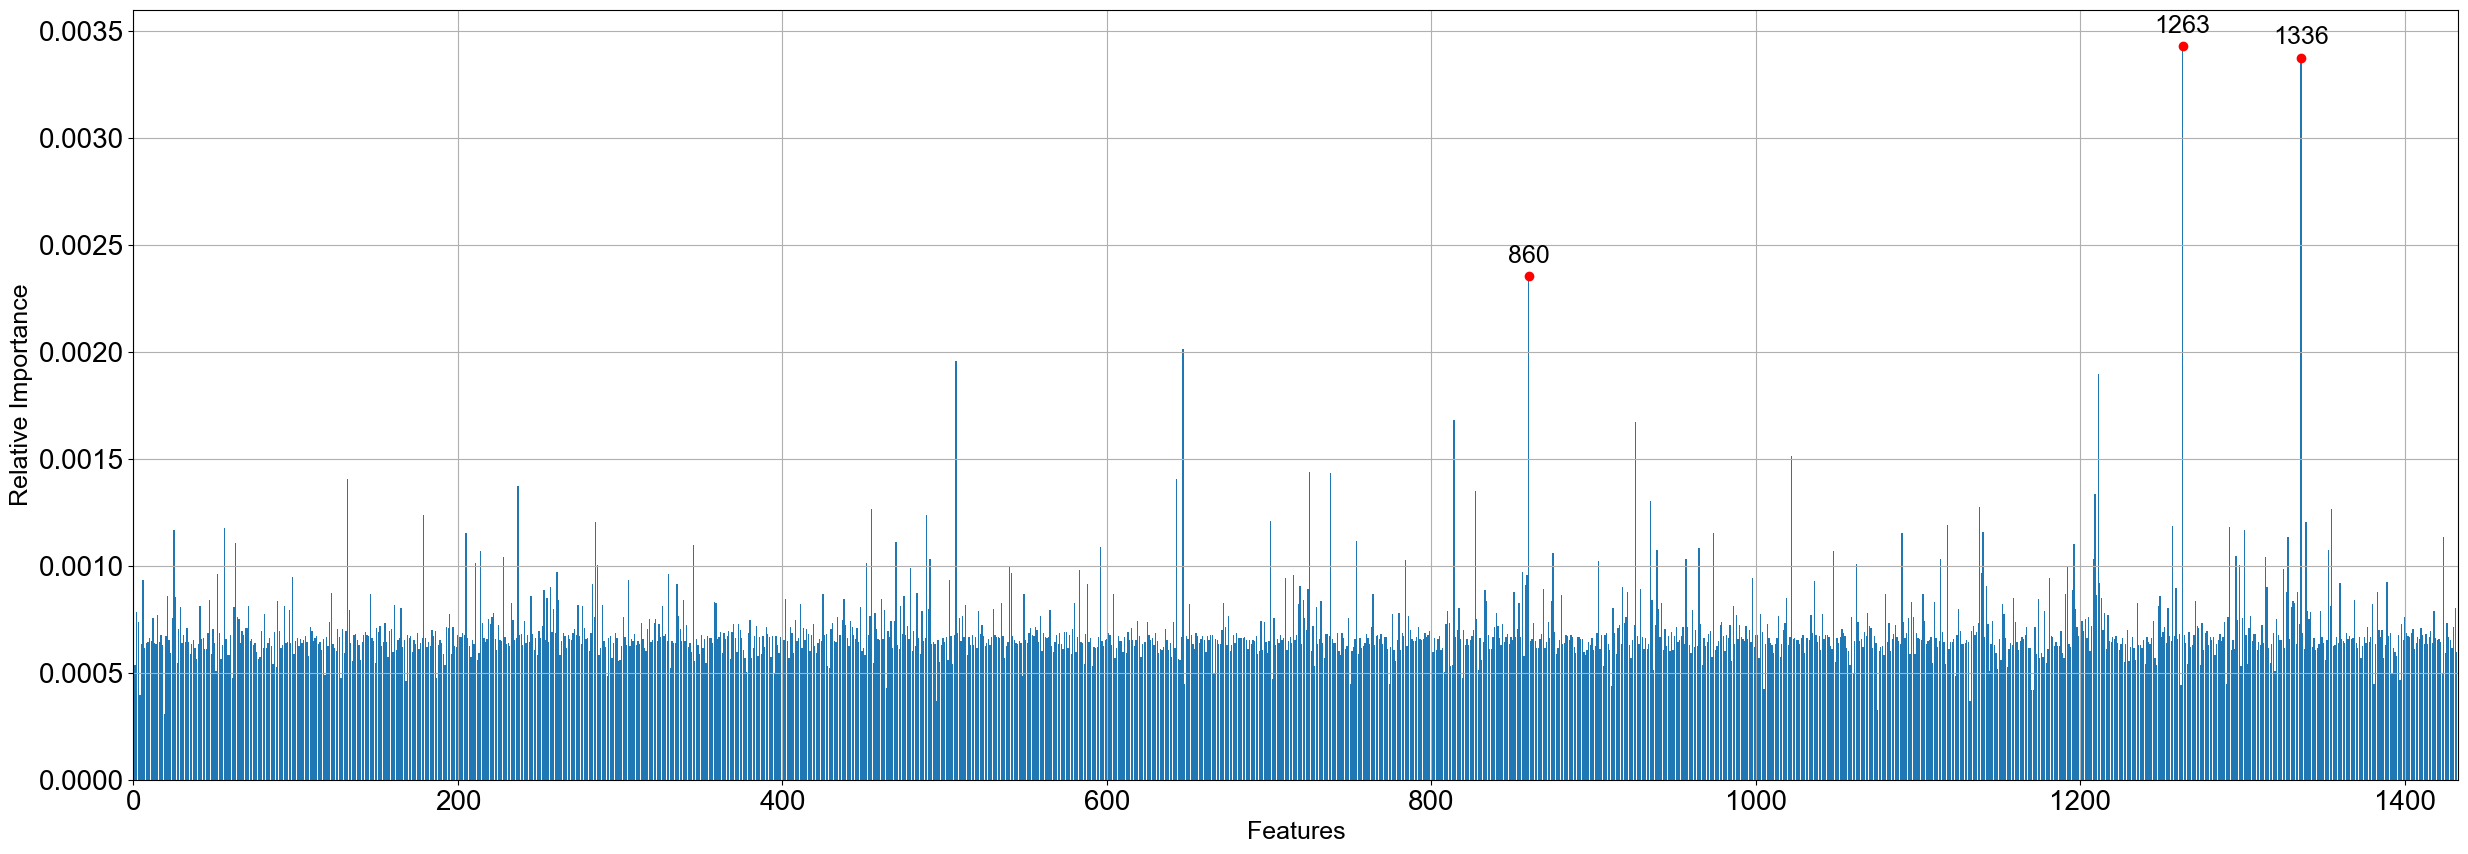

<module 'matplotlib.pyplot' from '/home/dwalke/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

In [18]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)
framework.plot_feature_importances(mark_top_n_peaks = 3, file_name="feature_importance_cora", dpi = 100 , font_size=20)

## T-SNE Plot for Cora

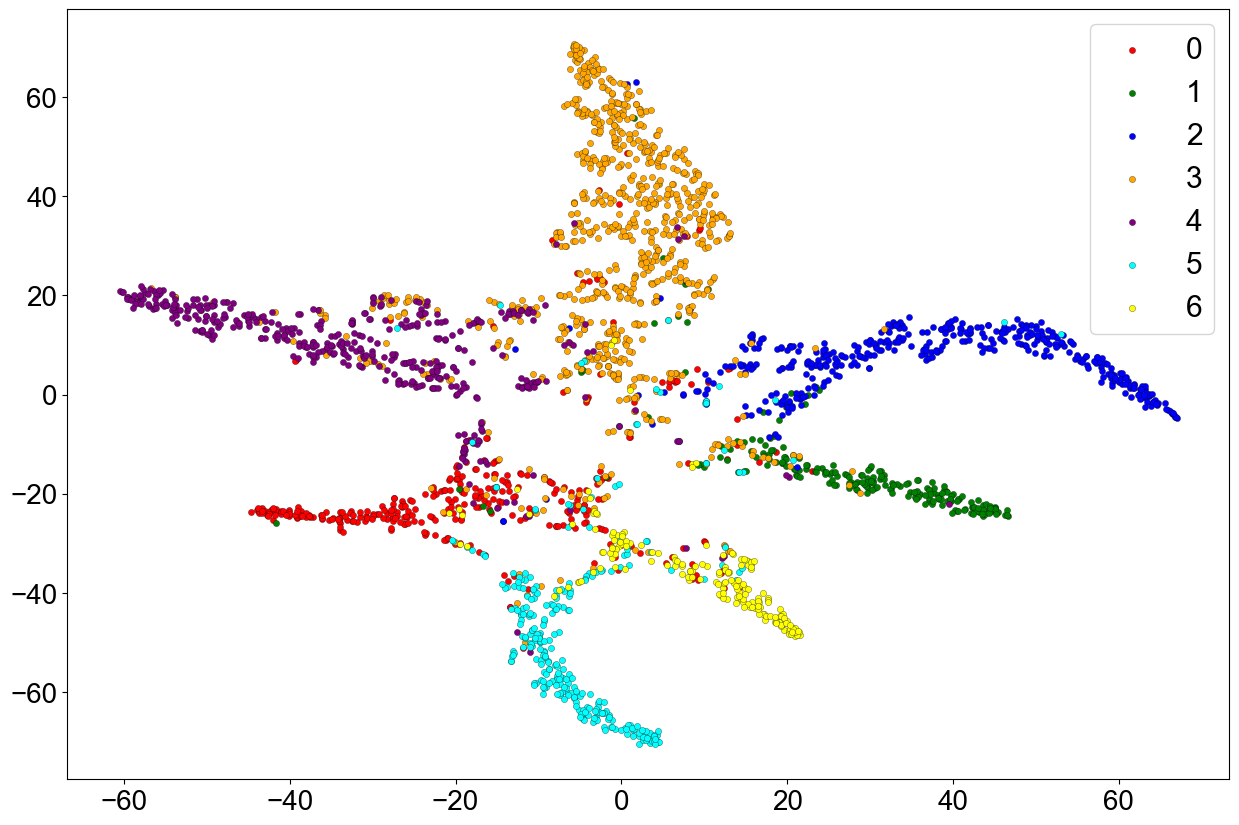

<module 'matplotlib.pyplot' from '/home/dwalke/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

In [19]:
dataset = name_to_sets[CORA]
y = dataset["y"]
X = dataset["X"]
edge_index = dataset["edge_index"]
label_to_color_map = colors = {
    0: (1.0, 0.0, 0.0),       # Red
    1: (0.0, 0.5, 0.0),       # Green
    2: (0.0, 0.0, 1.0),       # Blue
    3: (1.0, 0.65, 0.0),      # Orange
    4: (0.5, 0.0, 0.5),       # Purple
    5: (0.0, 1.0, 1.0),       # Cyan
    6: (1.0, 1.0, 0.0)        # Yellow
}

framework.plot_tsne(X, edge_index, y, label_to_color_map = label_to_color_map, dpi = 100, file_name="tsne_graphaware", fig_size=(15,10), font_size=20)

## TSNE only with logistic regression

In [20]:
store = cora_store
user_functions = [None]
clfs = [store["LogisticRegression"][0]["model"]]
attention_configs = [None]

framework_without_neighbors, end_time = fit_dataset(CORA,user_functions=user_functions, hops_list= [0], clfs = clfs, attention_configs= attention_configs)
acc_dict = predict_dataset(CORA, framework_without_neighbors)
print(acc_dict)

{'test_acc': 0.598, 'val_acc': 0.586}


/home/dwalke/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1172: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


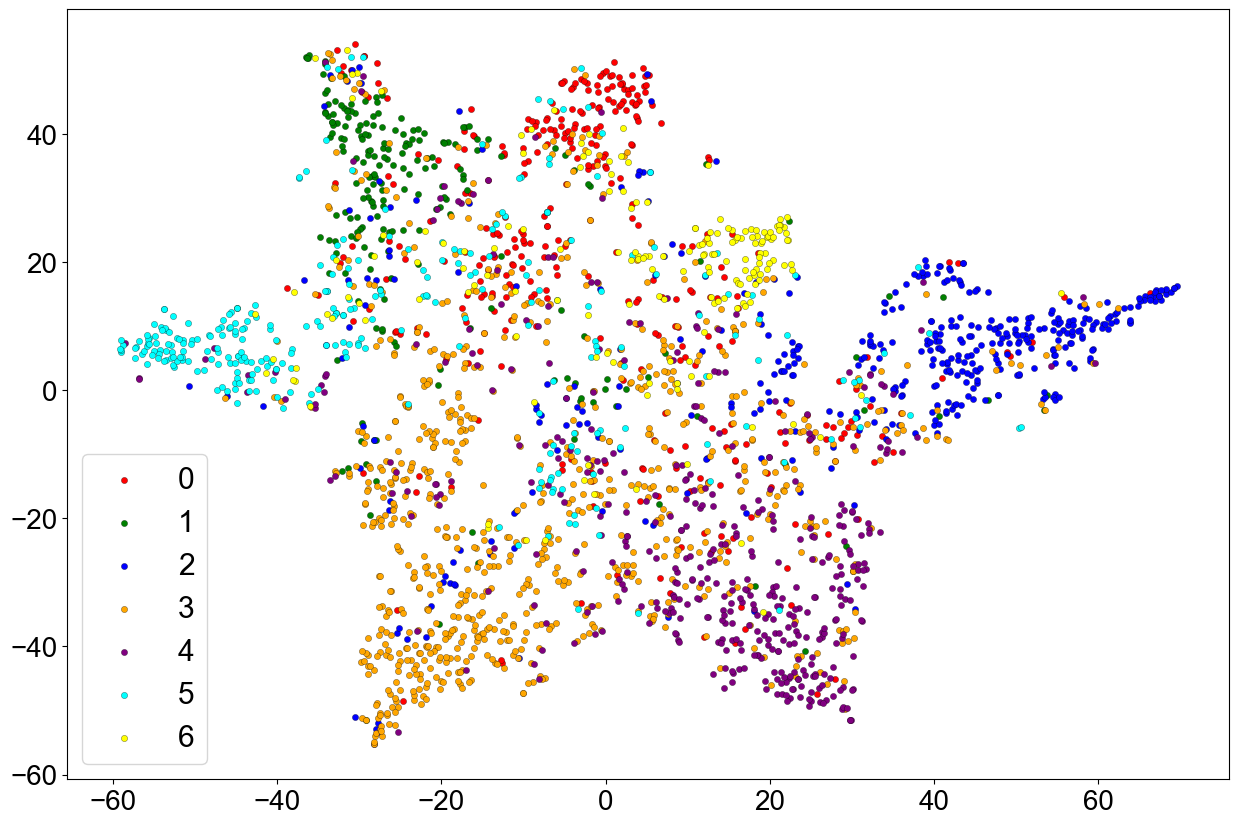

<module 'matplotlib.pyplot' from '/home/dwalke/.local/lib/python3.10/site-packages/matplotlib/pyplot.py'>

<Figure size 640x480 with 0 Axes>

In [21]:
dataset = name_to_sets[CORA]
y = dataset["y"]
X = dataset["X"]
edge_index = dataset["edge_index"]
label_to_color_map = colors = {
    0: (1.0, 0.0, 0.0),       # Red
    1: (0.0, 0.5, 0.0),       # Green
    2: (0.0, 0.0, 1.0),       # Blue
    3: (1.0, 0.65, 0.0),      # Orange
    4: (0.5, 0.0, 0.5),       # Purple
    5: (0.0, 1.0, 1.0),       # Cyan
    6: (1.0, 1.0, 0.0)        # Yellow
}

framework_without_neighbors.plot_tsne(X, edge_index, y, label_to_color_map = label_to_color_map, dpi = 100, file_name="tsne_without_neighbors", fig_size=(15,10), font_size=20)